In [36]:
!pip install umap-learn hdbscan


In [17]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import umap


In [19]:
import glob

file_paths = glob.glob('/content/sample_data/*.txt')
print("Files found:", file_paths)


Files found: []


In [20]:
import glob
import pandas as pd

# Look in the root /content directory
file_paths = glob.glob('/content/*.txt')
print("Files found:", file_paths)

# Preview one file manually
if file_paths:
    with open(file_paths[0]) as f:
        for _ in range(10):
            print(f.readline())
else:
    print("Still no files found — check if files are uploaded.")


Files found: ['/content/BNBFDUSD_20250314.txt', '/content/BNBFDUSD_20250315 (1).txt', '/content/BNBFDUSD_20250316 (1).txt', '/content/BNBFDUSD_20250314 (1).txt', '/content/BNBFDUSD_20250317.txt', '/content/BNBFDUSD_20250315.txt', '/content/BNBFDUSD_20250317 (1).txt', '/content/BNBFDUSD_20250316.txt']
Time,Price,Quantity,IsMarketMaker,NumTrades,M

2025-03-14 00:00:02.764823793 +0530 IST,579.41000000,0.49600000,true,1,true

2025-03-14 00:00:02.781509697 +0530 IST,579.38000000,0.01300000,true,1,true

2025-03-14 00:00:02.8057318 +0530 IST,579.38000000,0.10400000,true,1,true

2025-03-14 00:00:03.902576812 +0530 IST,579.34000000,0.49600000,true,1,true

2025-03-14 00:00:03.905083833 +0530 IST,579.32000000,2.73900000,true,2,true

2025-03-14 00:00:03.911723355 +0530 IST,579.31000000,3.56500000,true,1,true

2025-03-14 00:00:03.920745941 +0530 IST,579.30000000,5.22100000,true,2,true

2025-03-14 00:00:04.190545456 +0530 IST,579.40000000,1.72600000,false,1,true

2025-03-14 00:00:04.434392223 +0530 

In [21]:
from google.colab import files
uploaded = files.upload()


Saving BNBFDUSD_20250317 (1).txt to BNBFDUSD_20250317 (1) (1).txt
Saving BNBFDUSD_20250316 (1).txt to BNBFDUSD_20250316 (1) (1).txt
Saving BNBFDUSD_20250315 (1).txt to BNBFDUSD_20250315 (1) (1).txt
Saving BNBFDUSD_20250314 (1).txt to BNBFDUSD_20250314 (1) (1).txt
Saving BNBFDUSD_20250317.txt to BNBFDUSD_20250317 (2).txt
Saving BNBFDUSD_20250316.txt to BNBFDUSD_20250316 (2).txt
Saving BNBFDUSD_20250315.txt to BNBFDUSD_20250315 (2).txt
Saving BNBFDUSD_20250314.txt to BNBFDUSD_20250314 (2).txt


In [25]:
import pandas as pd
import glob

# Get all txt files in /content
file_paths = glob.glob('/content/*.txt')
print(f"Found {len(file_paths)} files")

# Read and clean all files
dfs = []
for fp in file_paths:
    df = pd.read_csv(fp, header=0)

    # Clean up Time column (remove timezone info)
    df['Time'] = pd.to_datetime(df['Time'].str.split('+').str[0].str.strip(), format='mixed', errors='coerce')


    # Drop the last column 'M' if it exists and always true
    if 'M' in df.columns:
        df = df.drop(columns=['M'])

    dfs.append(df)

# Combine all data into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
print(df.shape)
df.head()


Found 16 files
(2027280, 85)


,Time,Price,Quantity,IsMarketMaker,NumTrades,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,...,AskPriceL16,AskQtyL16,AskPriceL17,AskQtyL17,AskPriceL18,AskQtyL18,AskPriceL19,AskQtyL19,AskPriceL20,AskQtyL20
0,2025-03-14 00:00:02.764823793,579.41,0.496,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-14 00:00:02.781509697,579.38,0.013,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-14 00:00:02.805731800,579.38,0.104,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-14 00:00:03.902576812,579.34,0.496,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-14 00:00:03.905083833,579.32,2.739,True,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
import pandas as pd
import glob

file_paths = glob.glob('/content/*.txt')
print(f"Found {len(file_paths)} files")

dfs = []
for fp in file_paths:
    df = pd.read_csv(fp, header=0)

    # Remove timezone part and parse time flexibly
    df['Time'] = pd.to_datetime(df['Time'].str.split('+').str[0].str.strip(), format='mixed', errors='coerce')
    df = df.dropna(subset=['Time'])

    if 'M' in df.columns:
        df = df.drop(columns=['M'])

    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print(df.shape)
df.head()


Found 16 files
(2027280, 85)


,Time,Price,Quantity,IsMarketMaker,NumTrades,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,...,AskPriceL16,AskQtyL16,AskPriceL17,AskQtyL17,AskPriceL18,AskQtyL18,AskPriceL19,AskQtyL19,AskPriceL20,AskQtyL20
0,2025-03-14 00:00:02.764823793,579.41,0.496,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-14 00:00:02.781509697,579.38,0.013,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-14 00:00:02.805731800,579.38,0.104,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-14 00:00:03.902576812,579.34,0.496,True,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-14 00:00:03.905083833,579.32,2.739,True,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Make sure it's sorted
df = df.sort_values('Time')

# Set time as index
df = df.set_index('Time')

# Add a side column (buy = taker is buyer)
df['Side'] = df['IsMarketMaker'].map({True: 'sell', False: 'buy'})

# Resample to 1s intervals
agg = df.resample('1S').agg({
    'Price': 'last',
    'Quantity': 'sum',
    'NumTrades': 'sum',
})

# Compute rolling midprice returns
agg['log_return'] = np.log(agg['Price'] / agg['Price'].shift(1))

# Rolling volatility (over 10s, 30s)
agg['volatility_10s'] = agg['log_return'].rolling(10).std()
agg['volatility_30s'] = agg['log_return'].rolling(30).std()


<ipython-input-26-a5e9a3b31201>:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  agg = df.resample('1S').agg({


In [27]:
# Calculate rolling VWAP (weighted average price)
df['Value'] = df['Price'] * df['Quantity']
vwap_1s = df.resample('1S').agg({'Value': 'sum', 'Quantity': 'sum'})
vwap_1s['VWAP'] = vwap_1s['Value'] / vwap_1s['Quantity']

# Merge with main 1s bar
agg = agg.join(vwap_1s['VWAP'])

# VWAP shift (momentum indicator)
agg['VWAP_shift_10s'] = agg['VWAP'] - agg['VWAP'].shift(10)
agg['VWAP_shift_30s'] = agg['VWAP'] - agg['VWAP'].shift(30)

# Buy/Sell volume for imbalance
buy_qty = df[df['Side'] == 'buy']['Quantity'].resample('1S').sum()
sell_qty = df[df['Side'] == 'sell']['Quantity'].resample('1S').sum()

agg['buy_volume'] = buy_qty
agg['sell_volume'] = sell_qty
agg['volume_imbalance'] = (buy_qty - sell_qty) / (buy_qty + sell_qty)


<ipython-input-27-23bb7fbd5e82>:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  vwap_1s = df.resample('1S').agg({'Value': 'sum', 'Quantity': 'sum'})
<ipython-input-27-23bb7fbd5e82>:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  buy_qty = df[df['Side'] == 'buy']['Quantity'].resample('1S').sum()
<ipython-input-27-23bb7fbd5e82>:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sell_qty = df[df['Side'] == 'sell']['Quantity'].resample('1S').sum()


In [28]:
# Drop rows with missing values from rolling calculations
agg_clean = agg.dropna()

# Select relevant features
features = agg_clean[[
    'log_return',
    'volatility_10s',
    'volatility_30s',
    'VWAP_shift_10s',
    'VWAP_shift_30s',
    'volume_imbalance',
    'buy_volume',
    'sell_volume',
    'Quantity',       # total volume
    'NumTrades'
]]


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


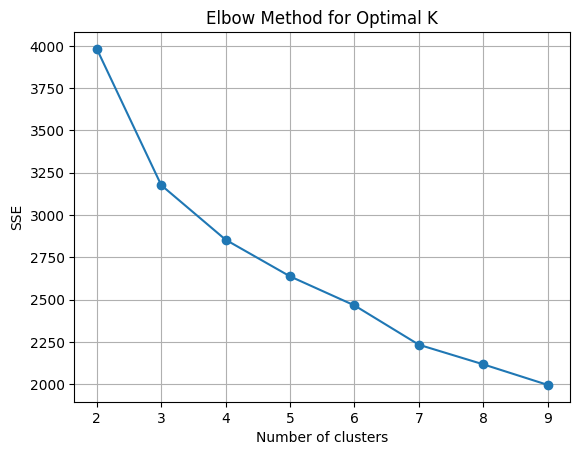

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow plot to find best K
sse = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()


In [31]:
# Fit final KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
agg_clean['kmeans_regime'] = kmeans.fit_predict(X_scaled)


<ipython-input-31-4c5e8a2b7477>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_clean['kmeans_regime'] = kmeans.fit_predict(X_scaled)


In [32]:
# Simple profile for each cluster
regime_summary = agg_clean.groupby('kmeans_regime').agg({
    'volatility_10s': 'mean',
    'VWAP_shift_10s': 'mean',
    'volume_imbalance': 'mean',
    'Quantity': 'mean',
    'log_return': 'std'
}).round(4)

regime_summary


,volatility_10s,VWAP_shift_10s,volume_imbalance,Quantity,log_return
kmeans_regime,,,,,
0,0.0004,-0.0544,-0.3436,15.7117,0.0002
1,0.0002,0.0683,0.7349,11.3801,0.0002
2,0.0001,-0.1046,-0.6036,9.9815,0.0001
3,0.0003,0.2107,0.2960,113.5056,0.0004


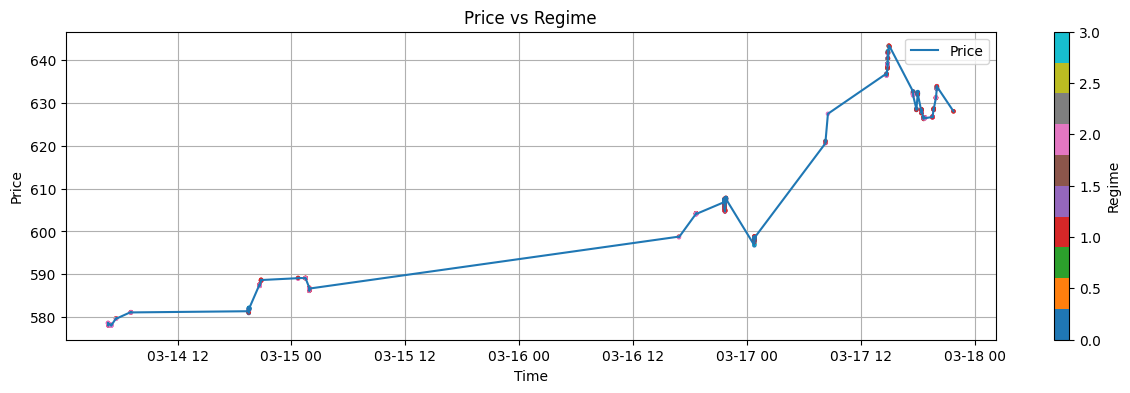

In [33]:
# Regime over time
plt.figure(figsize=(15,4))
plt.plot(agg_clean.index, agg_clean['Price'], label='Price')
plt.scatter(agg_clean.index, agg_clean['Price'], c=agg_clean['kmeans_regime'], cmap='tab10', s=5)
plt.title('Price vs Regime')
plt.xlabel('Time')
plt.ylabel('Price')
plt.colorbar(label='Regime')
plt.legend()
plt.grid()
plt.show()


In [34]:
transitions = agg_clean['kmeans_regime'].shift().astype(str) + '→' + agg_clean['kmeans_regime'].astype(str)
transition_counts = transitions.value_counts(normalize=True)
transition_counts.head()


,proportion
kmeans_regime,
0.0→0,0.187364
1.0→1,0.176471
2.0→2,0.135076
1.0→2,0.126362
2.0→1,0.124183
